# Anomaly Detection

In [2]:
%matplotlib notebook

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import ceil
from sklearn.decomposition import PCA
from sklearn.preprocessing import  normalize
from sklearn.exceptions import NotFittedError

## Data Loading

For this workshop we'll use the retail dataset, which has spikes during Black Friday and holidays that we could consider anomalous, or at least worth detecting. We'll sum the dataset down into all stores for the purpose of this workshop. Feel free to select a single store or group of stores to experiment with different results.

In [14]:
df = pd.read_csv(
    "datasets/retail/sales.csv.gz", 
    names=['store', 'dept', 'date', 'sales', 'holiday'], 
    index_col='date', 
    parse_dates=True, 
    header=0,
    usecols=['date', 'dept', 'store', 'sales'],
)

sales = df.groupby(['date'])['sales'].sum()
sales.index = pd.to_datetime(sales.index)

In [15]:
def plot_sales(s):
    fig, ax = plt.subplots(figsize=(9,6))
    sales.plot(ax=ax)
    ax.set_ylabel("sales ($)")
    
    fig.tight_layout()
    return ax


_ = plot_sales(sales)

<IPython.core.display.Javascript object>

## PCA/FFT

One of the simplest methods of anomaly detection is to use a discrete FFT to extract features from a fixed-length sliding window and then apply PCA to learn a threshold for the explained variance and robustness to error. Once the thresholds are learned, any window above the threshold is anomalous, and the amount above the threshold is the "strength" of the anomaly. 

In [18]:
class FrequencyThresholdAnomalies(object):
    
    def __init__(self, window=6, stride=1, n_components=None, pca_percentile=99.95):
        # Length of the window to detect spikes in, we'll use a 6 week window
        self.window = window
        
        # Amount to move the window over, we'll move one week at a time.
        self.stride=stride
        
        # The threshold for PCA explained variance to accept
        self.pca_percentile = pca_percentile
        
        # Compute the number of components as a majority of the window size
        if n_components is None:
            n_components = int(ceil(self.window+1.0)/2.0)
        
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        
    def fit(self, series):
        # Extract the windowed FFT features
        X = self.windowed_instances(series)
        X = self.fft_features(X)
        
        # Fit the PCA model and transform X
        X = self.pca.fit_transform(X)
        
        # Use the thresholds to learn the magnitudes for anomaly detection
        self.thresholds_ = np.zeros((self.n_components))
        for i in range(self.n_components):
            self.thresholds_[i] = np.percentile(X[:,i], self.pca_percentile)
        
        return self
    
    def transform(self, series):
        X = self.windowed_instances(series)
        X = self.fft_features(X)
        return self.pca.transform(X)

    def predict(self, series, return_strengths=True):
        X = self.transform(series)
        anomalies = np.array([
            self.is_anomaly(Xi) for Xi in X
        ])
        
        # process the array into an array the same sies as the series
        tmp = np.zeros_like(series)
        tmp[0:(series.shape[0] - self.window):self.stride] = anomalies
        anomalies = np.convolve(tmp, np.ones((self.window)))
        
        return anomalies 

    def windowed_instances(self, series):
        X = [
            series.values[i:i+self.window].reshape(-1)
            for i in range(0, series.shape[0]-self.window, self.stride)
        ]
        return np.vstack(X)
    
    def fft_features(self, X):
        Xp = np.abs(np.fft.fft(X))
        Xp = Xp[:, 0:int(ceil((self.window+1.0)/2))]
        return normalize(Xp)
    
    def is_anomaly(self, instance):
        for val, thr in zip(instance, self.thresholds_):
            if val > thr:
                return True
        return False

<IPython.core.display.Javascript object>


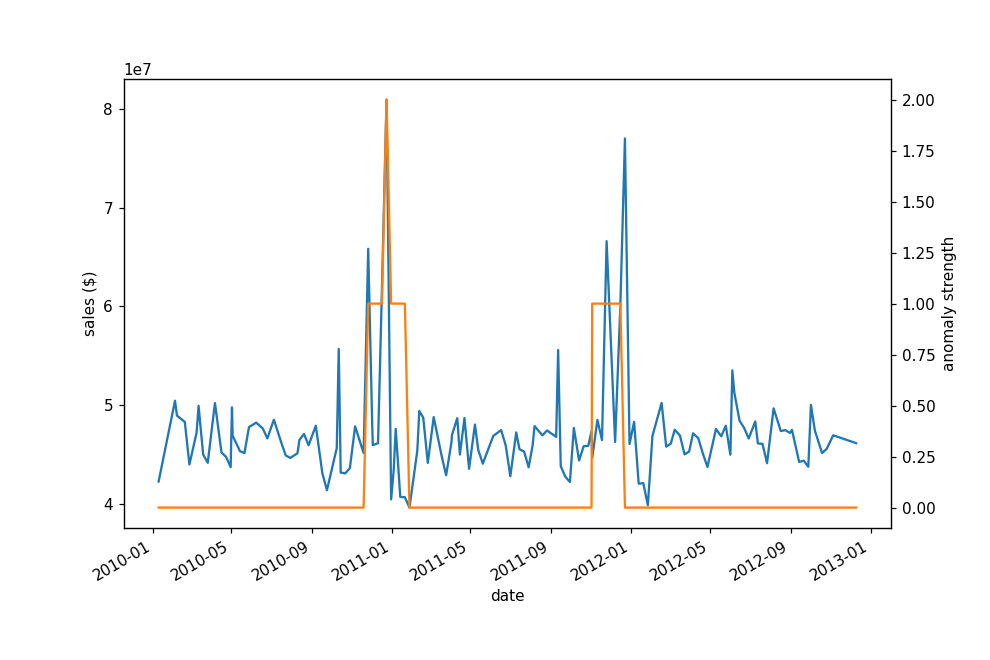

In [30]:
def plot_anomalies(s, model):
    fig, ax = plt.subplots(figsize=(9,6))
    s.plot(ax=ax)
    ax.set_ylabel("sales ($)")
    
    model.fit(s)
    y = model.predict(s)
    
    ax2 = ax.twinx()
    pd.Series(y[:-1*model.window+1], index=s.index).plot(ax=ax2, c='C1')
    ax2.set_ylabel("anomaly strength")
    
    return ax


model = FrequencyThresholdAnomalies()
_ = plot_anomalies(sales, model)

## Autoencoder/Decoder Anomaly Detection

In this section we'll use a Keras convolutional autoencoder/decoder model for anomaly detection. The idea with this model is that we'll train on "normal data" and then find anything outside of the normal data to be an anomaly. 

In [64]:
def create_instances(series, window=16):
    # Ensure that all data going into a deep neural network is standardized!
    mu = series.mean()
    std = series.std()
    series = (series - mu) / std
    
    # Create the instances
    instances = [
        series[i:(i+window)] 
        for i in range(len(series)-window)
    ]
    return np.stack([instances], axis=-1)
    
    
X = create_instances(sales)

In [65]:
X.shape

(127, 16, 1)

### Build the Model

In [66]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(X.shape[1], X.shape[2])),
    # An 8 layer convolutional autoencoder
    layers.Conv1D(
        filters=8, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    # Helps prevent overfitting
    layers.Dropout(rate=0.2),
    # Latent Space Representation
    layers.Conv1D(
        filters=4, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    # Flip latent space for decoding
    layers.Conv1DTranspose(
        filters=4, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    # Helps prevent overfitting
    layers.Dropout(rate=0.2),
    # An 8 layer convolutional autodecoder
    layers.Conv1DTranspose(
        filters=8, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    # Output layer for anomaly detection
    layers.Conv1DTranspose(
        filters=1, kernel_size=7, padding="same"
    ),
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 8, 8)              64        
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 8)              0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4, 4)              228       
_________________________________________________________________
conv1d_transpose_18 (Conv1DT (None, 8, 4)              116       
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 4)              0         
_________________________________________________________________
conv1d_transpose_19 (Conv1DT (None, 16, 8)             232       
_________________________________________________________________
conv1d_transpose_20 (Conv1DT (None, 16, 1)            

In [71]:
history = model.fit(X, X, epochs=50, batch_size=32, validation_split=0.1, callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
])

Epoch 1/50
4/4 [==============================] - 0s 12ms/step - loss: 1.0133 - val_loss: 0.1314
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 0.9752 - val_loss: 0.1288
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 0.9685 - val_loss: 0.1261
Epoch 4/50
4/4 [==============================] - 0s 7ms/step - loss: 0.9655 - val_loss: 0.1237
Epoch 5/50
4/4 [==============================] - 0s 7ms/step - loss: 0.9302 - val_loss: 0.1215
Epoch 6/50
4/4 [==============================] - 0s 7ms/step - loss: 0.8853 - val_loss: 0.1201
Epoch 7/50
4/4 [==============================] - 0s 6ms/step - loss: 0.8852 - val_loss: 0.1189
Epoch 8/50
4/4 [==============================] - 0s 6ms/step - loss: 0.8792 - val_loss: 0.1177
Epoch 9/50
4/4 [==============================] - 0s 6ms/step - loss: 0.8615 - val_loss: 0.1170
Epoch 10/50
4/4 [==============================] - 0s 6ms/step - loss: 0.8376 - val_loss: 0.1178
Epoch 11/50
4/4 [=====================

<IPython.core.display.Javascript object>


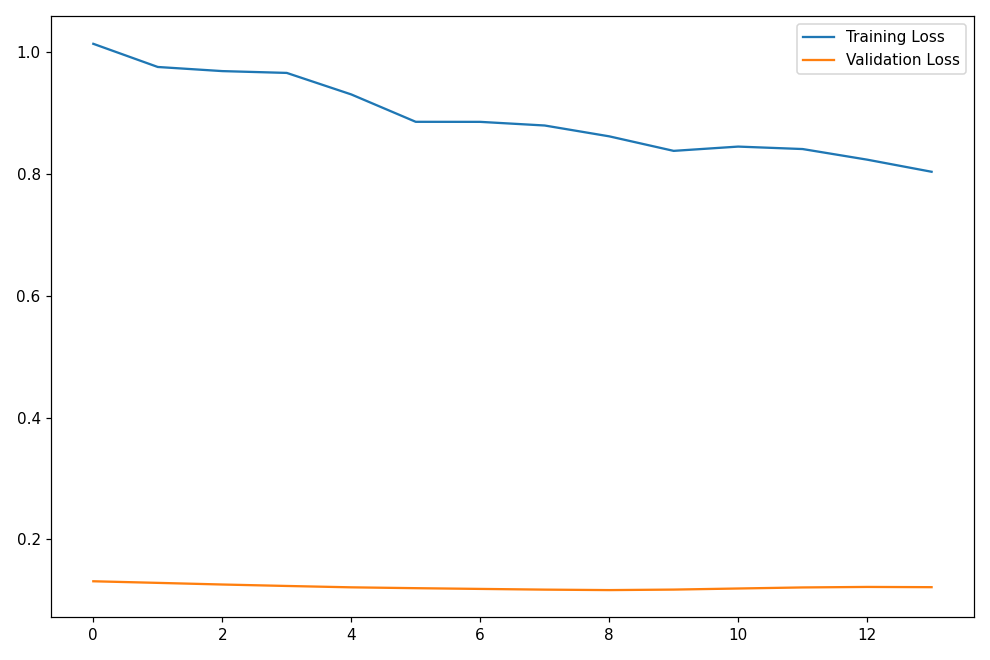

In [72]:
def plot_training_loss(history):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(history.history["loss"], label="Training Loss")
    ax.plot(history.history["val_loss"], label="Validation Loss")
    ax.legend()
    fig.tight_layout()
    
    return ax


_ = plot_training_loss(history)

### Detecting Anomalies 

1. Find MAE loss on training samples
2. Find maximum MAE loss value - use this as the threshold for anomaly detection
3. If reconstruction loss is greater than threshold, label as anomaly.

<IPython.core.display.Javascript object>


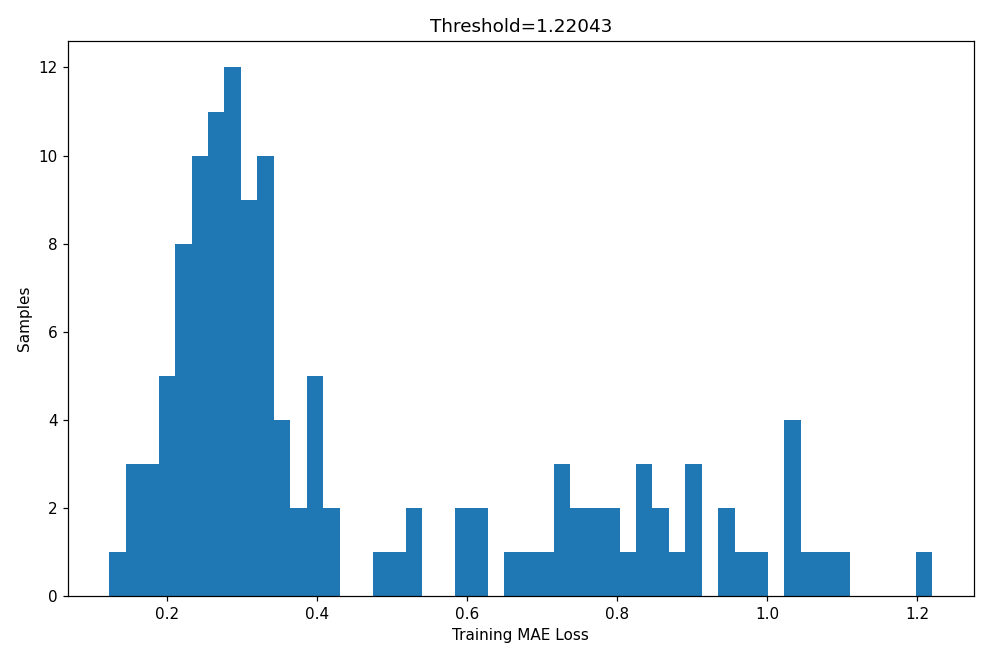

In [73]:
def plot_mae_loss_hist(X, model):
    fig, ax = plt.subplots(figsize=(9,6))
    
    Xpred = model.predict(X)
    loss = np.mean(np.abs(Xpred-X), axis=1)
    
    ax.hist(loss, bins=50)
    ax.set_xlabel("Training MAE Loss")
    ax.set_ylabel("Samples")
    
    threshold = np.max(loss)
    ax.set_title(f"Threshold={threshold:0.5f}")
    
    fig.tight_layout()
    return ax, threshold


_, threshold = plot_mae_loss_hist(X, model)

<IPython.core.display.Javascript object>


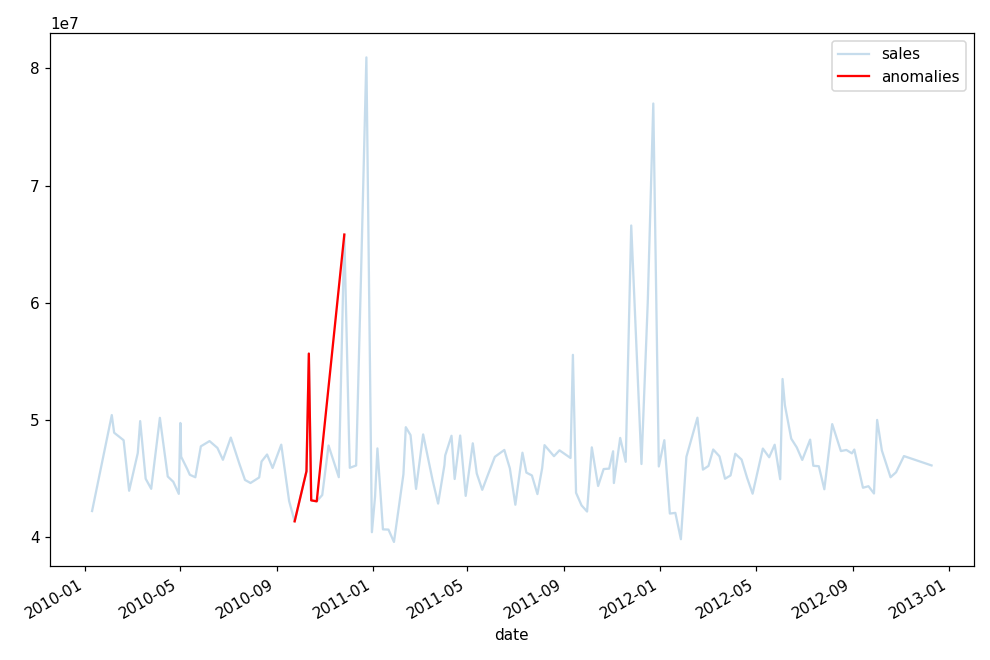

11 anomalies


In [85]:
def plot_anomalies(s, X, model):
    fig, ax = plt.subplots(figsize=(9,6))
    
    Xpred = model.predict(X)
    loss = np.mean(np.abs(Xpred-X), axis=1)
    threshold = np.max(loss) - np.std(loss)
    
    anomalies = loss > threshold
    print(f"{np.sum(anomalies)} anomalies")
    
    steps = 3
    aidx = []
    for i in range(steps-1, len(X)-steps+1):
        if np.all(anomalies[i-steps+1:i]):
            aidx.append(i)
    
    sales.plot(legend=False, ax=ax, alpha=0.25)
    sales.iloc[aidx].plot(legend=False, ax=ax, color='r', label="anomalies")
    
    ax.legend()
    
    fig.tight_layout()
    return ax


_ = plot_anomalies(sales, X, model)